In [197]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
# from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from deepproblog.dataset import Dataset as DPLDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from deepproblog.dataset import DataLoader as DPLDataLoader

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from retinaface import RetinaFace
import csv

In [198]:
# GLOBAL VARS
dataset_size = None
lr_faces = 1e-4
lr_scenes = 1e-4
lr_combination_model = 5e-4
lr_model = 1e-4
batch_size = 32
log_iter = 2
epochs = 30
global_emotion_label = 'emo8'
nr_clusters = 9

In [199]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)
cropped_faces_dir = os.path.join(findingemo_dir, "faces")
print("cropped_faces_dir:", cropped_faces_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models
cropped_faces_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\faces


In [200]:
df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))
print("Dataframe loaded. Number of entries:", len(df))

Dataframe loaded. Number of entries: 25867


In [201]:
EMOTION_SETS = [["Serenity", "Joy", "Ecstasy"],
                    ["Acceptance", "Trust", "Admiration"],
                    ["Apprehension", "Fear", "Terror"],
                    ["Distraction", "Surprise", "Amazement"],
                    ["Pensiveness", "Sadness", "Grief"],
                    ["Boredom", "Disgust", "Loathing"],
                    ["Annoyance", "Anger", "Rage"],
                    ["Interest", "Anticipation", "Vigilance"]]
                
def emo_8_mapping(e):
    for leaf in EMOTION_SETS:
        if e in leaf:
            return leaf[1]
        
def emo_3_mapping(v):
    if v < -1:
        return "sad"
    if v > 1:
        return "happy"
    else:
        return "neutral"

In [202]:
if global_emotion_label == 'emo8':
    df['emotion'] = df['emotion'].apply(emo_8_mapping).str.lower()
if global_emotion_label == 'emotion':
    df['emotion'] = df['emotion'].str.lower()
if global_emotion_label == 'emo3':
    df['emotion'] = df['valence'].apply(emo_3_mapping).str.lower()

In [203]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0


In [204]:
len(df)

25867

In [205]:
if dataset_size is not None:
    df = df.iloc[:dataset_size]

In [206]:
fe_labels = df['emotion'].unique().tolist()
fe_labels.sort()
print("Emotion labels:", fe_labels)

Emotion labels: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']


In [207]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [208]:
# Create a dictionary with the average valence arousal values for each emotion label
emotion_va = {}

for emo in fe_labels:
    emo_df = df[df['emotion'] == emo]
    avg_valence = emo_df['valence'].mean()
    avg_arousal = emo_df['arousal'].mean()
    emotion_va[emo] = (avg_valence, avg_arousal)

In [209]:
emotion_va

{'anger': (-1.5756457564575646, 3.5912259122591226),
 'anticipation': (0.5624470428740891, 2.463650228774784),
 'disgust': (-0.876, 2.441),
 'fear': (-1.3390254060807996, 3.239067055393586),
 'joy': (1.9020501138952164, 2.9552961275626424),
 'sadness': (-1.5707317073170732, 3.4221388367729833),
 'surprise': (0.47635135135135137, 2.5664414414414414),
 'trust': (1.4142011834319526, 2.5694561848408)}

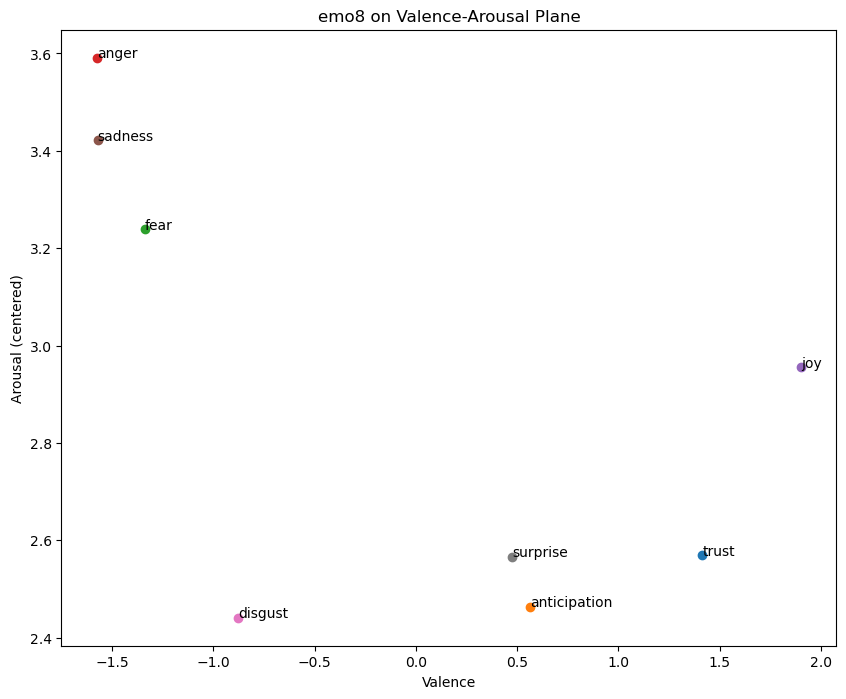

In [210]:
VALENCE_BINS = np.linspace(-3, 3, num=21)
AROUSAL_BINS = np.linspace(0, 6, num=21)

def to_bin(value, bins):
    return int(np.abs(bins - value).argmin())

plt.figure(figsize=(10, 8))
emotion_va_bins = {}

for emo in df['emotion'].unique():
    avg_valence, avg_arousal = emotion_va[emo]
    valence_bin = to_bin(avg_valence, VALENCE_BINS)
    arousal_bin = to_bin(avg_arousal, AROUSAL_BINS)
    emotion_va_bins[emo] = (valence_bin, arousal_bin)
    plt.scatter(avg_valence, avg_arousal, label=emo)
    plt.text(avg_valence, avg_arousal, emo)

plt.xlabel('Valence')
plt.ylabel('Arousal (centered)')
plt.title(f'{global_emotion_label} on Valence-Arousal Plane')
plt.show()

In [211]:
emotion_va_bins

{'trust': (15, 9),
 'anticipation': (12, 8),
 'fear': (6, 11),
 'anger': (5, 12),
 'joy': (16, 10),
 'sadness': (5, 11),
 'disgust': (7, 8),
 'surprise': (12, 9)}

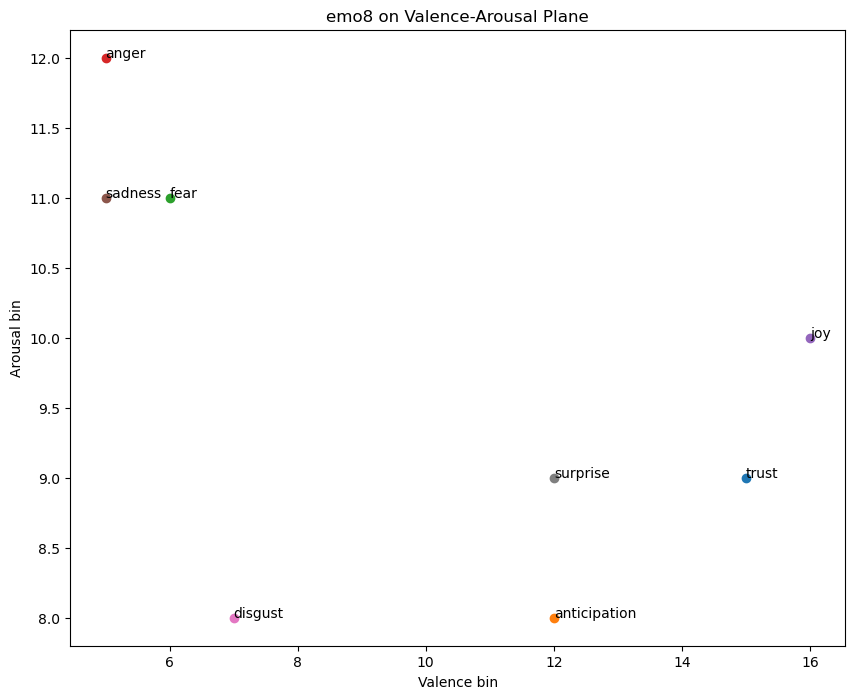

In [212]:
# Now plot the bins
plt.figure(figsize=(10, 8))

for emo in df['emotion'].unique():
    valence_bin, arousal_bin = emotion_va_bins[emo]
    plt.scatter(valence_bin, arousal_bin, label=emo)
    plt.text(valence_bin, arousal_bin, emo)

plt.xlabel('Valence bin')
plt.ylabel('Arousal bin')
plt.title(f'{global_emotion_label} on Valence-Arousal Plane')
plt.show()

In [213]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [214]:
# get the counts of the labels of emotion
df['emotion'].value_counts()

emotion
joy             7024
anticipation    5901
trust           3549
sadness         2665
anger           2439
fear            2401
disgust         1000
surprise         888
Name: count, dtype: int64

In [215]:
if dataset_size is not None:
    N = dataset_size
else:
    N = len(df)
    
indices = list(range(N))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices length:", len(train_indices))
print("Test indices length:", len(test_indices))

Train indices length: 20693
Test indices length: 5174


In [216]:
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# let cuDNN pick the fastest kernels for this image size
torch.backends.cudnn.benchmark = True

True


In [217]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig


emotion_transform = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model_base = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
face_model_base.to(DEVICE)
config = AutoConfig.from_pretrained("trpakov/vit-face-expression")
print(config.id2label)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [218]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model_base = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model_base.load_state_dict(state_dict)
scene_model_base.to(DEVICE)
print("Loaded pretrained models")

Loaded pretrained models


In [219]:
df_boxes = pd.read_csv(os.path.join(findingemo_dir, "face_boxes_5.csv"))
# Based on boxes_df we can add the column nr_faces for each original image in df
df['nr_faces'] = df.index.map(df_boxes['index'].value_counts()).fillna(0).astype(int)

In [220]:
get_category_name = lambda idx: scene_categories[idx]

In [221]:
def show_pretrained_model_predictions_on_sample(sample_idx):
    row = df.iloc[sample_idx]
    img_path = os.path.join(findingemo_dir, row['image_path'])
    img = Image.open(img_path).convert("RGB")
    
    # Convert to numpy array for drawing
    img_array = np.array(img)
    
    # Get all face boxes for this image
    face_boxes = df_boxes[df_boxes['index'] == sample_idx].sort_values('face_rank')
    
    # Draw bounding boxes and predictions on the image
    for _, box_row in face_boxes.iterrows():
        x1, y1, x2, y2 = int(box_row['x1']), int(box_row['y1']), int(box_row['x2']), int(box_row['y2'])
        face_rank = int(box_row['face_rank'])
        
        model_output = torch.load(os.path.join(data_dir, "pretrained_logits", "faces", f"face_{sample_idx}_{face_rank}.pt")).to(DEVICE).unsqueeze(0)
        probs_output = torch.softmax(model_output, dim=1)
        probs = probs_output[0].cpu().detach().numpy()
        
        # Get top prediction
        top_idx = np.argmax(probs)
        top_label = f"{fer_classes[top_idx]}: {probs[top_idx]:.2f}"
        
        # Draw rectangle
        cv2.rectangle(img_array, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Calculate text size for better positioning
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        thickness = 2
        (text_width, text_height), baseline = cv2.getTextSize(top_label, font, font_scale, thickness)
        
        # Position text above the box if there's space, otherwise below
        if y1 - text_height - 10 > 0:
            text_y = y1 - 10
        else:
            text_y = y2 + text_height + 10
        
        # Draw text with background for better visibility
        cv2.rectangle(img_array, (x1, text_y - text_height - 5), 
                    (x1 + text_width + 5, text_y + 5), (0, 255, 0), -1)
        cv2.putText(img_array, top_label, (x1, text_y), 
                    font, font_scale, (0, 0, 0), thickness)
        
    # Display image with bounding boxes and predictions
    plt.figure(figsize=(15, 10))
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"Image Index: {sample_idx}, Valence: {row['valence']}, Arousal: {row['arousal']}, Emotion: {row['emotion']}", fontsize=16)
    plt.show()

    scene_logits = torch.load(os.path.join(data_dir, "pretrained_logits", "scenes", f"scene_{sample_idx}.pt")).to(DEVICE)
    scene_probs = torch.softmax(scene_logits, dim=0)
   

    # Show top 3 from base model (365 categories)
    top3_base = torch.topk(scene_probs, 3)
    print("Base model (365 categories):")
    for prob, idx in zip(top3_base.values.cpu(), top3_base.indices.cpu()):
        print(f"  {get_category_name(idx)}: {prob:.4f}")
    print("")


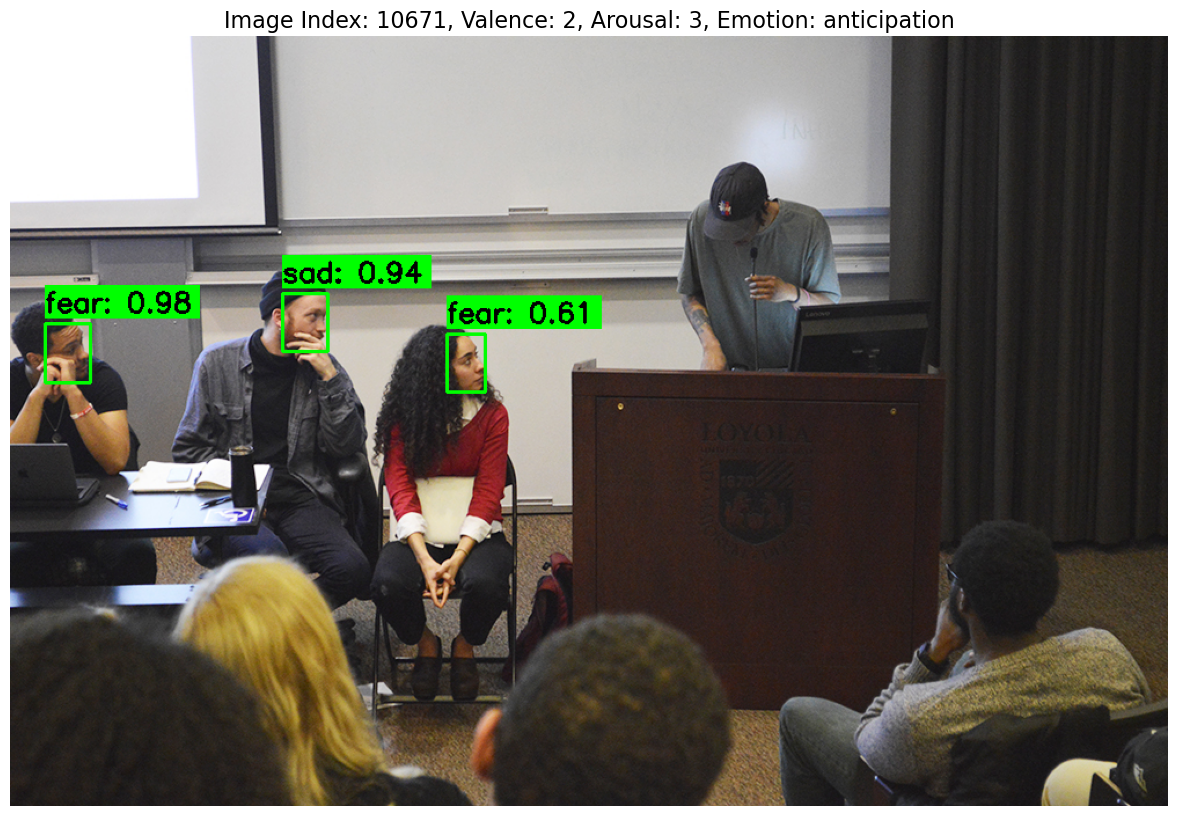

Base model (365 categories):
  lecture_room: 0.6076
  legislative_chamber: 0.2501
  classroom: 0.0849



In [222]:
show_pretrained_model_predictions_on_sample(np.random.choice(test_indices))

# DPL with symbolic knowledge about the data

In [223]:
class DeviceAwareModule(nn.Module):
    """Wrapper that automatically handles device placement for any module"""
    def __init__(self, module):
        super().__init__()
        self.module = module
    
    def forward(self, *args, **kwargs):
        # Move all tensor inputs to model's device
        device = next(self.module.parameters()).device
        
        def to_device(x):
            if isinstance(x, torch.Tensor):
                return x.to(device)
            elif isinstance(x, (list, tuple)):
                return type(x)(to_device(item) for item in x)
            elif isinstance(x, dict):
                return {k: to_device(v) for k, v in x.items()}
            return x
        
        args = to_device(args)
        kwargs = to_device(kwargs)
        return self.module(*args, **kwargs)
    
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.module, name)

In [224]:
LABEL_TO_ID = {emo: i for i, emo in enumerate(fe_labels)}
print("LABEL_TO_ID:", LABEL_TO_ID)

LABEL_TO_ID: {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5, 'surprise': 6, 'trust': 7}


In [225]:
from deepproblog.utils.confusion_matrix import ConfusionMatrix

from sklearn.metrics import confusion_matrix as sklearn_cm, precision_recall_fscore_support

def evaluate_dpl_with_metrics(model, dataset):
    """Enhanced DPL evaluate function that returns detailed metrics"""
    from deepproblog.utils.confusion_matrix import ConfusionMatrix
    
    confusion_matrix = ConfusionMatrix()
    model.eval()
    
    all_labels = []
    all_preds = []
    
    for i, gt_query in enumerate(tqdm(dataset.to_queries(), desc="Evaluating DPL", leave=False)):
        test_query = gt_query.variable_output()
        answer = model.solve([test_query])[0]
        actual = str(gt_query.output_values()[0])
        
        if len(answer.result) == 0:
            predicted = "no_answer"
        else:
            max_ans = max(answer.result, key=lambda x: answer.result[x])
            p = answer.result[max_ans]
            predicted = str(max_ans.args[gt_query.output_ind[0]])
        
        confusion_matrix.add_item(predicted, actual)
        all_labels.append(actual)
        all_preds.append(predicted)
    
    # Convert to numpy arrays with label indices
    label_to_idx = {str(i): i for i in range(len(fe_labels))}
    y_true = np.array([label_to_idx.get(label, -1) for label in all_labels])
    y_pred = np.array([label_to_idx.get(pred, -1) for pred in all_preds])
    
    # Remove any "no_answer" predictions (-1)
    valid_mask = (y_true >= 0) & (y_pred >= 0)
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    
    # Calculate sklearn confusion matrix
    cm = sklearn_cm(y_true, y_pred, labels=range(len(fe_labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(fe_labels)), zero_division=0
    )
    
    # Overall accuracy
    accuracy = confusion_matrix.accuracy()
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'dpl_confusion_matrix': confusion_matrix,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }


def print_dpl_detailed_metrics(results, label_names):
    """Print detailed metrics for DPL results"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Emotion':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")

In [226]:
from deepproblog.utils.standard_networks import MLP

In [227]:
x = torch.load(data_dir + "/pretrained_logits/faces/face_0_0.pt")

In [228]:
print(x.shape)

torch.Size([7])


# Initialize the models, network and final DPL model

In [229]:
face_val_model_raw = MLP(
    7,        # input size
    64, 32,   # hidden layers
    21,       # output size (valence bins)   
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
face_val_model = DeviceAwareModule(face_val_model_raw).to(DEVICE)

face_val_network = Network(face_val_model, "face_val_model", batching=True)
face_val_network.optimizer = torch.optim.Adam(face_val_model.parameters(), lr=1e-3)

In [230]:
face_aro_model_raw = MLP(
    7,        # input size
    64, 32,   # hidden layers
    21,       # output size (arousal bins)   
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
face_aro_model = DeviceAwareModule(face_aro_model_raw).to(DEVICE)

face_aro_network = Network(face_aro_model, "face_aro_model", batching=True)
face_aro_network.optimizer = torch.optim.Adam(face_aro_model.parameters(), lr=1e-3)

In [231]:
scene_val_model_raw = MLP(
    365,        # input size
    256, 64,   # hidden layers
    21,       # output size (valence bins)   
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
scene_val_model = DeviceAwareModule(scene_val_model_raw).to(DEVICE)

scene_val_network = Network(scene_val_model, "scene_val_model", batching=True)
scene_val_network.optimizer = torch.optim.Adam(scene_val_model.parameters(), lr=1e-3)

In [232]:
scene_aro_model_raw = MLP(
    365,        # input size
    256, 64,   # hidden layers
    21,       # output size (arousal bins)   
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
scene_aro_model = DeviceAwareModule(scene_aro_model_raw).to(DEVICE)

scene_aro_network = Network(scene_aro_model, "scene_aro_model", batching=True)
scene_aro_network.optimizer = torch.optim.Adam(scene_aro_model.parameters(), lr=1e-3)

In [233]:
class FaceFeatureDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        # Load all face logits (7 each), average; if none, use neutral
        face_rows = df_boxes[df_boxes['index'] == idx].sort_values('face_rank')
        face_features_list = []
        for _, box_row in face_rows.iterrows():
            face_rank = int(box_row['face_rank'])
            face_prediction_file = os.path.join(self.feature_dir, "faces", f"face_{idx}_{face_rank}.pt")
            face_features = torch.load(face_prediction_file, map_location="cpu")  # (7,)
            face_features_list.append(face_features)

        if len(face_features_list) == 0:
            face_avg = torch.zeros(7, dtype=torch.float32)
            face_avg[4] = 1.0  # neutral
        else:
            face_avg = torch.stack(face_features_list).mean(dim=0)  # (7,)

        return face_avg
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

face_features_train = FaceFeatureDataset(train_indices, os.path.join(data_dir, "pretrained_logits"))
face_features_test = FaceFeatureDataset(test_indices, os.path.join(data_dir, "pretrained_logits"))        

In [234]:
class SceneFeatureDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        scene_prediction_file = os.path.join(self.feature_dir, "scenes", f"scene_{idx}.pt")
        scene_features = torch.load(scene_prediction_file, map_location="cpu")  # (7,)

        return scene_features
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scene_features_train = SceneFeatureDataset(train_indices, os.path.join(data_dir, "pretrained_logits"))
scene_features_test = SceneFeatureDataset(test_indices, os.path.join(data_dir, "pretrained_logits"))

In [235]:
emotion_va_bins

{'trust': (15, 9),
 'anticipation': (12, 8),
 'fear': (6, 11),
 'anger': (5, 12),
 'joy': (16, 10),
 'sadness': (5, 11),
 'disgust': (7, 8),
 'surprise': (12, 9)}

In [236]:
def closest_emotion(CV, CA):
    # Extract values from Constant objects
    cv_val = CV.value if isinstance(CV, Constant) else CV
    ca_val = CA.value if isinstance(CA, Constant) else CA
    
    closest_emo = None
    min_distance = float('inf')
    for emo, (EV, EA) in emotion_va_bins.items():
        DX = cv_val - EV
        DY = ca_val - EA
        D = (DX * DX + DY * DY) ** 0.5
        if D < min_distance:
            min_distance = D
            closest_emo = emo

    emo_id = LABEL_TO_ID[closest_emo]

    return Constant(emo_id)

In [237]:
from deepproblog.engines import ApproximateEngine
heuristic2 = ApproximateEngine.geometric_mean

model = Model(os.path.join(prolog_dir, "model_5_1.pl"), [face_val_network, face_aro_network, scene_val_network, scene_aro_network])
# model.set_engine(ExactEngine(model))
model.set_engine(ApproximateEngine(model, 10, heuristic2))

model.register_foreign(closest_emotion, "closest_emotion", 2, 1)

model.add_tensor_source("face_features_train", face_features_train)
model.add_tensor_source("scene_features_train", scene_features_train)
model.add_tensor_source("face_features_test", face_features_test)
model.add_tensor_source("scene_features_test", scene_features_test)

In [238]:
class FEQUeryDataset(DPLDataset):
    def __init__(self, indices, dataset_name):
        self.indices = indices
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        pass

    def to_query(self, idx):
        idx = self.indices[idx]
        label_str = df.iloc[idx]['emotion']
        label_id = LABEL_TO_ID[label_str]

        return Query(
            Term("final_emotion",
                Term("tensor", Term(f"face_features_{self.dataset_name}", Constant(idx))),
                Term("tensor", Term(f"scene_features_{self.dataset_name}", Constant(idx))),
                Constant(label_id)
                )
        )
    
train_dataset = FEQUeryDataset(train_indices, "train")
test_dataset = FEQUeryDataset(test_indices, "test")

In [239]:
train_dataset.to_query(0)

(1.0::final_emotion(tensor(face_features_train(2405)),tensor(scene_features_train(2405)),4), {})

In [240]:
def debug_query(model, pred_name, *args, substitution=None):
    """Helper to test intermediate predicates"""
    query = Query(Term(pred_name, *args), substitution=substitution)
    print(f"\n{'='*60}")
    print(f"Testing: {pred_name}")
    print(f"{'='*60}")
    model.eval()
    results = model.solve([query])
    result = results[0].result
    
    # Print probabilities nicely
    for key, prob in sorted(result.items(), key=lambda x: -x[1]):
        print(f"  {key}: {prob:.4f}")
    
    return result

In [241]:
test_idx = np.random.choice(test_indices)

debug_query(model,
            "closest_emotion",
            Constant(5),
            Constant(12),
            Var("E"))

debug_query(model,
            "test_face_val_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Var("VBin"))

debug_query(model,
            "test_face_aro_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Var("ABin"))

debug_query(model,
            "test_scene_val_bin",
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("VBin"))

debug_query(model,
            "test_scene_aro_bin",
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("ABin"))

debug_query(model,
            "test_combine_val_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("CV"))

debug_query(model,
            "test_combine_aro_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("CA"))

debug_query(model,
            "final_emotion",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Constant(LABEL_TO_ID[df.iloc[test_idx]['emotion']]))

print("Debugging queries done.")


Testing: closest_emotion
  closest_emotion(5,12,0): 1.0000

Testing: test_face_val_bin
  test_face_val_bin(tensor(face_features_test(12193)),8): 0.0609
  test_face_val_bin(tensor(face_features_test(12193)),12): 0.0568
  test_face_val_bin(tensor(face_features_test(12193)),1): 0.0566
  test_face_val_bin(tensor(face_features_test(12193)),18): 0.0550
  test_face_val_bin(tensor(face_features_test(12193)),20): 0.0531
  test_face_val_bin(tensor(face_features_test(12193)),13): 0.0524
  test_face_val_bin(tensor(face_features_test(12193)),5): 0.0519
  test_face_val_bin(tensor(face_features_test(12193)),7): 0.0515
  test_face_val_bin(tensor(face_features_test(12193)),0): 0.0506
  test_face_val_bin(tensor(face_features_test(12193)),16): 0.0498

Testing: test_face_aro_bin
  test_face_aro_bin(tensor(face_features_test(12193)),0): 0.0671
  test_face_aro_bin(tensor(face_features_test(12193)),17): 0.0580
  test_face_aro_bin(tensor(face_features_test(12193)),5): 0.0571
  test_face_aro_bin(tensor(face_f

In [ ]:
train_loader = DPLDataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [243]:
train_obj = train_model(
    model,
    train_loader,
    5,
    batch_size=batch_size,
    log_iter=log_iter
)

Training  for 5 epoch(s)
Epoch 1
Iteration:  2 	s:6.9489 	Average Loss:  4.334870085120201
Iteration:  4 	s:16.3592 	Average Loss:  7.851691976189613
Iteration:  6 	s:12.8264 	Average Loss:  6.288310378789902
Iteration:  8 	s:12.0902 	Average Loss:  5.522166226059198
Iteration:  10 	s:11.6634 	Average Loss:  4.810750685632229
Iteration:  12 	s:12.5543 	Average Loss:  4.515112046152353
Iteration:  14 	s:12.3480 	Average Loss:  4.250451292842627
Iteration:  16 	s:12.2610 	Average Loss:  3.970181681215763
Iteration:  18 	s:11.9936 	Average Loss:  3.6256477162241936
Iteration:  20 	s:12.0579 	Average Loss:  3.4114834647625685
Iteration:  22 	s:12.3569 	Average Loss:  3.523930437862873
Iteration:  24 	s:11.9837 	Average Loss:  3.178126698359847
Iteration:  26 	s:12.3767 	Average Loss:  3.1057228334248066
Iteration:  28 	s:11.7233 	Average Loss:  2.9210910983383656
Iteration:  30 	s:12.4318 	Average Loss:  2.8178756134584546
Iteration:  32 	s:12.1512 	Average Loss:  2.8348735980689526
Iterat

KeyboardInterrupt: 

In [244]:
results = evaluate_dpl_with_metrics(model, test_dataset)
print_dpl_detailed_metrics(results, fe_labels)

Accuracy:  0.3693467336683417

Overall Metrics:
Accuracy: 0.3693

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.2500       0.0235       0.0429       511       
anticipation    0.2785       0.7828       0.4108       1183      
disgust         0.0000       0.0000       0.0000       199       
fear            0.0000       0.0000       0.0000       461       
joy             0.5419       0.6857       0.6054       1416      
sadness         0.3333       0.0039       0.0077       512       
surprise        0.0000       0.0000       0.0000       167       
trust           0.0000       0.0000       0.0000       725       
----------------------------------------------------------------------
Macro Avg       0.1755       0.1870       0.1334       5174      
Weighted Avg    0.2696       0.3693       0.2646       5174      


In [245]:
def plot_confusion_matrix(cm, label_names, normalize=False):
    """Plot confusion matrix with better formatting"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

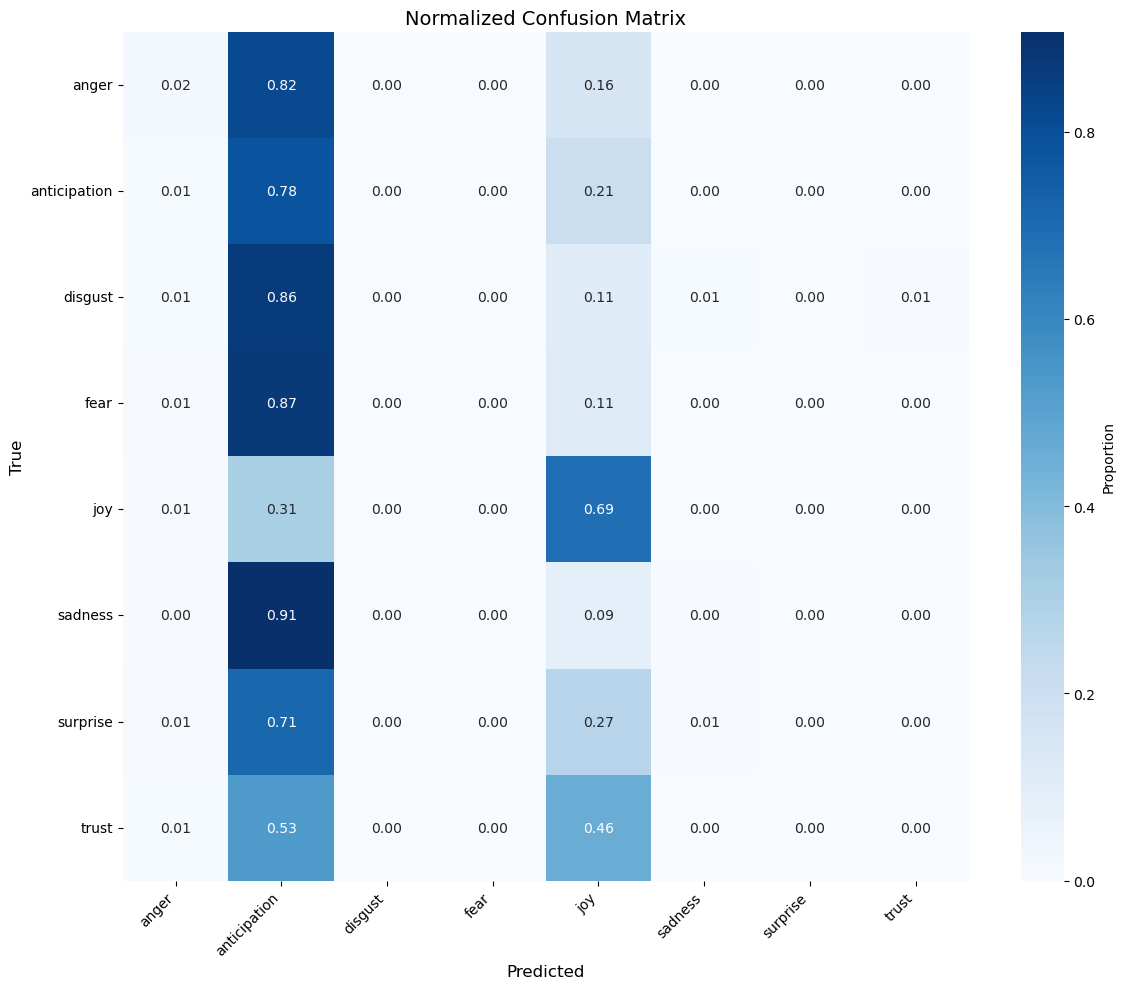

In [246]:
plot_confusion_matrix(results['confusion_matrix'], fe_labels, normalize=True)